### Прогнозирование продаж вина

Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие три года.

In [56]:
cd C:\Users\vlad\1. Machine Learning\Yandex Specialization\5.Applied Tasks Of Data Analysis\week1\data

C:\Users\vlad\1. Machine Learning\Yandex Specialization\5.Applied Tasks Of Data Analysis\week1\data


In [218]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import datetime

from dateutil.relativedelta import relativedelta
from itertools import product
from scipy import stats



%matplotlib inline
warnings.filterwarnings('ignore')

In [58]:
# Реализуем функцию для обратного преобразования Бокса-Кокса
def box_cox_transformation(lmbda, series):
    if lmbda == 0:
        return(np.exp(series))
    else:
        return(np.exp(np.log(lmbda*series+1)/lmbda))

### Загрузка и визуализация ряда

In [59]:
data = pd.read_csv('monthly-australian-wine-sales.csv', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.head()

,sales
month,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


Так-как продажи в тыс литрах, преобразуем к литрам

In [60]:
data['sales'] = data['sales']*1000
data.head()

,sales
month,
1980-01-01,15136000
1980-02-01,16733000
1980-03-01,20016000
1980-04-01,17708000
1980-05-01,18019000


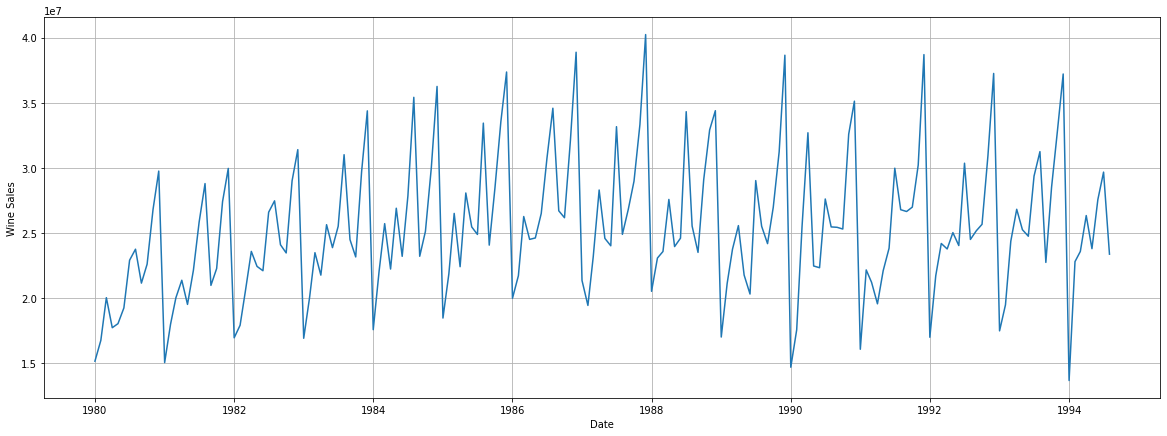

In [61]:
# Для визуализации ВР
def plot_sereis(series):
    plt.figure(figsize=(20,7))
    plt.plot(series)
    plt.grid(True)
    plt.xlabel('Date')
    plt.ylabel('Wine Sales')
    
plot_sereis(data['sales'])

Сперва проанализируем ряд. Можно выделить:
- нелинейный тренд
- явная годова сезонность
- дисперсия нестационарная (вначале меньше, заетем увеличивается)

Такой ряд явно не является стационарным, проверим формально, применив критерий Дики-Фуллера

In [62]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['sales'])[1])

Критерий Дики-Фуллера: p=0.051161


Значение пограничное. Критерий говорит, что такой ряд можно принять как стационарный, однако это неправда. Мы явно наблюдаем переменную дисперсию и нелинейный тренд, следовательно ряд не может являться стационарным.

Взглянем на отдельные компоненты ряда, применив STL - декомпазицию. STL - декомпозиция это набор евристик, позволяющий взглянуть на основные компоненты рядя:
- тренд
- сезонность 
- распределение остатков

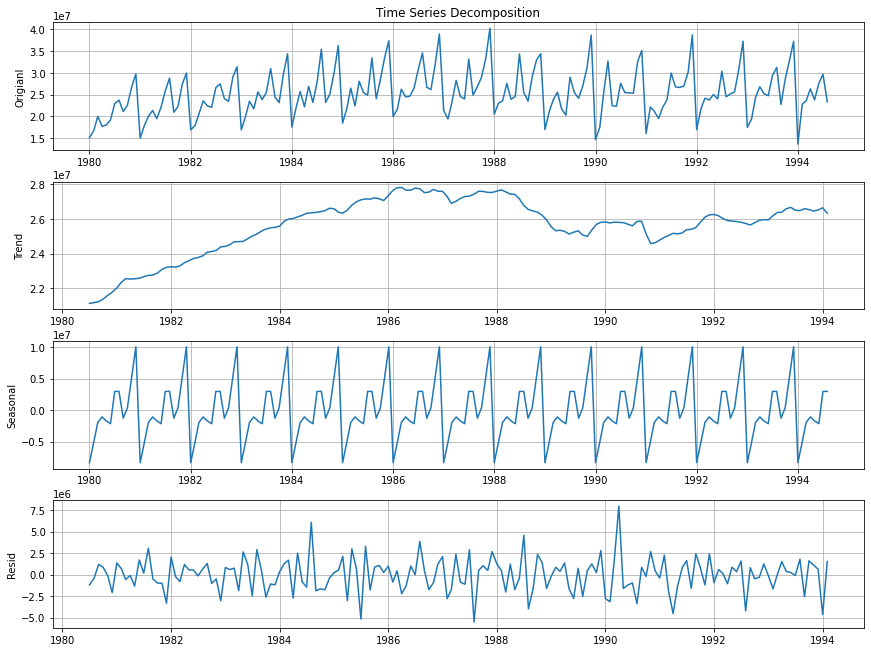

In [94]:
# Возникли проблемы с обычной отрисовкой, рисует не так как хочется, поэтому создал функцию отрисовки декомпозиции
def plot_decomposition(series, figsize = (12, 9), grid=True):
    ts_compnts = sm.tsa.seasonal_decompose(series)
    titles = ['Origianl', 'Trend', 'Seasonal', 'Resid']

    fig, ax = plt.subplots(nrows=4, ncols=1,figsize=figsize)
    plt.tight_layout()
    ax[0].set_title('Time Series Decomposition')
    
    ax[0].plot(series)
    ax[1].plot(ts_compnts.trend)
    ax[2].plot(ts_compnts.seasonal)
    ax[3].plot(ts_compnts.resid)
    
    for indx, title in enumerate(titles):
        ax[indx].set_ylabel(title)
        ax[indx].grid(True)
        
plot_decomposition(data['sales'])

Проанализировав, можно заметить:
- тренд имеет сложную структуру (повышается, уменьшается, затем снова повышается)
- сезонная компонента ярко выражена 

### Стабилизация дисперсии ряда

Дисперсия нашего ряда нестационарна, стабилизируем её методом Бокса-Кокса, использовав готовую реализацию

In [96]:
data['sales_box_cox'], lmbda = stats.boxcox(data['sales'])
print("Optimal Lambda: %f" %lmbda)
print("Diki-Fuller Criterion: p=%f" % sm.tsa.stattools.adfuller(data['sales_box_cox'])[1])

Optimal Lambda: 0.236675
Diki-Fuller Criterion: p=0.029565


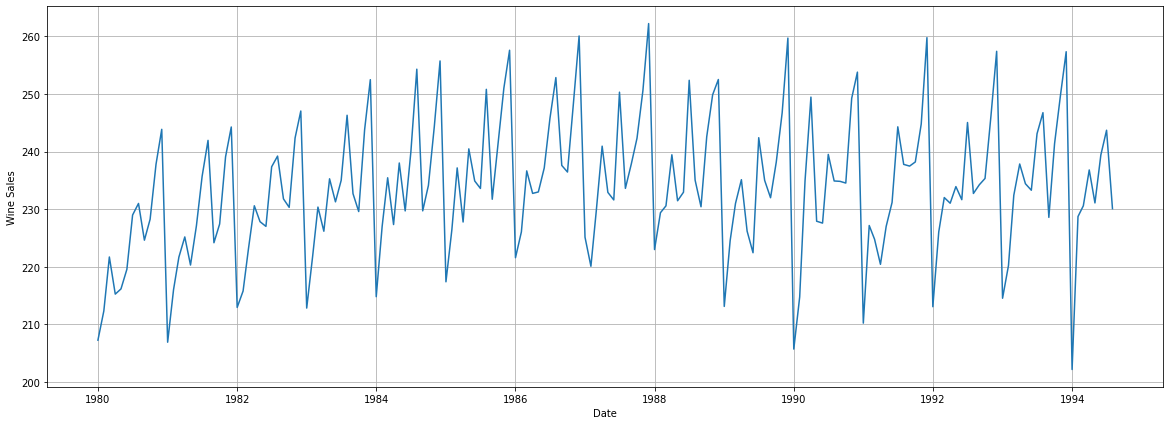

In [99]:
plot_sereis(data['sales_box_cox'])

Дисперсия ряда явно стала лучше. Критерий Дики-Фуллера говорит, что ряд является стационарным. Однако это не так, мы видим, что явно присутствует выраженная сезонность и тренд. Критерий Дики-Фуллера это всего лишь инструмент и несовершенный, поэтому если видно, что ряд явно нестационарный, то нельзя слепо верить критерию. 

### Получение стационарности
Так как в ряде присутствует сезонная компонента, то применим сезонное дифференцирование.

In [102]:
data['sales_box_cox_seas_diff'] = data['sales_box_cox'] - data['sales_box_cox'].shift(12)

Взглянем на STL - декомпозицию для продифференцированного ряда

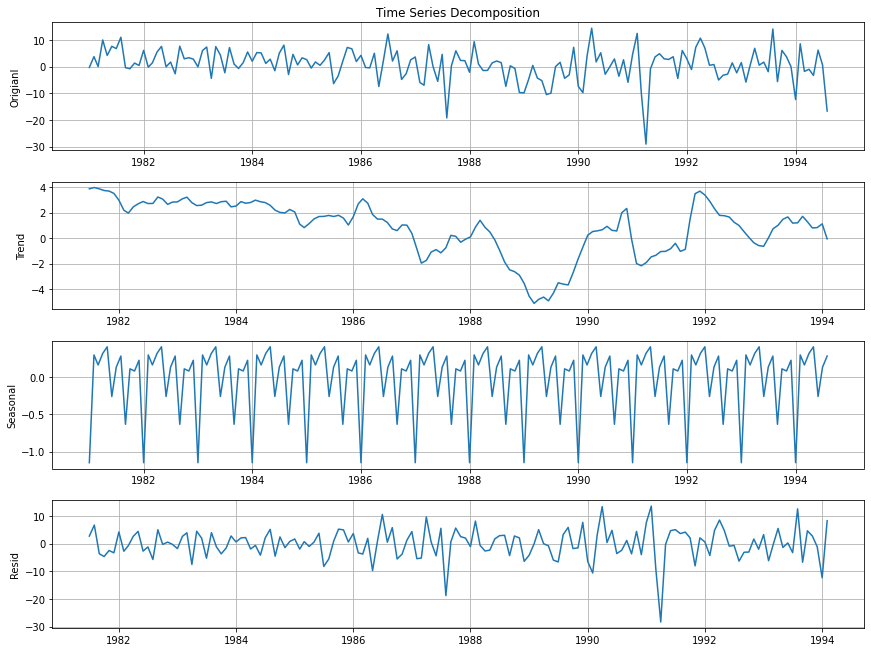

In [110]:
plot_decomposition(data['sales_box_cox_seas_diff'][12:])

Взглянем на критерий Дики-Фуллера

In [112]:
print("Diki-Fuller Criterion: p=%f" % sm.tsa.stattools.adfuller(data['sales_box_cox_seas_diff'][12:])[1])

Diki-Fuller Criterion: p=0.128317


Ряд все еще является нестационарным. Применим первые разности

In [114]:
data['sales_box_cox_seas_diff_1'] = data['sales_box_cox_seas_diff'] - data['sales_box_cox_seas_diff'].shift(1)

Снова взглянем на STL - декомпозицию после применения сезонных и первых разностей

Diki-Fuller Criterion: p=0.000002


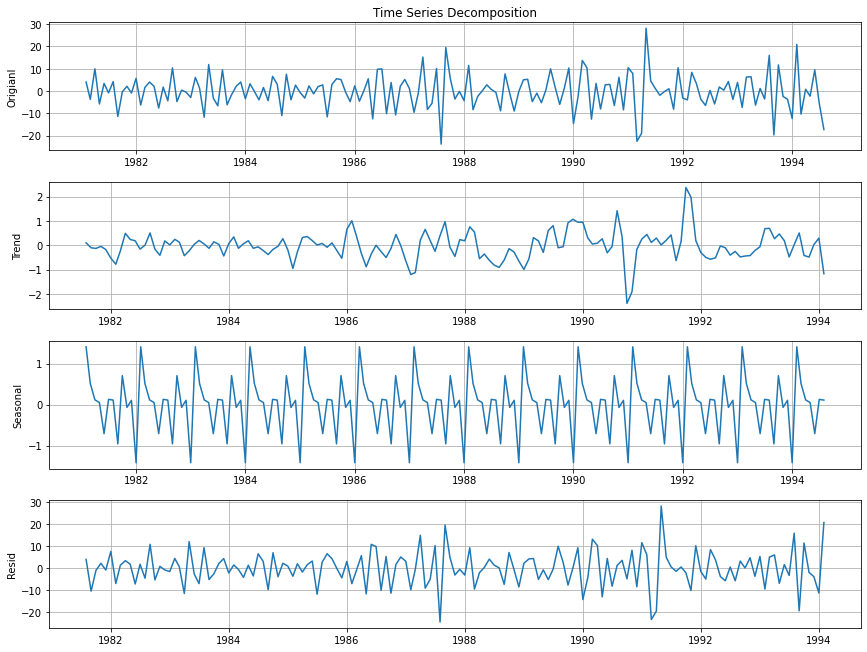

In [119]:
plot_decomposition(data['sales_box_cox_seas_diff_1'][13:])
print("Diki-Fuller Criterion: p=%f" % sm.tsa.stattools.adfuller(data['sales_box_cox_seas_diff_1'][13:])[1])

Теперь ряд действительно является стационарным, критерий Дики-Фуллера явно свидетельствует об этом.

Тренд теперь не имеет явных закономерностей и колеблется около нуля

### Модель ARIMA и подбор параметров
Определим параметры p,P,q,Q по графикам ACF и PACF

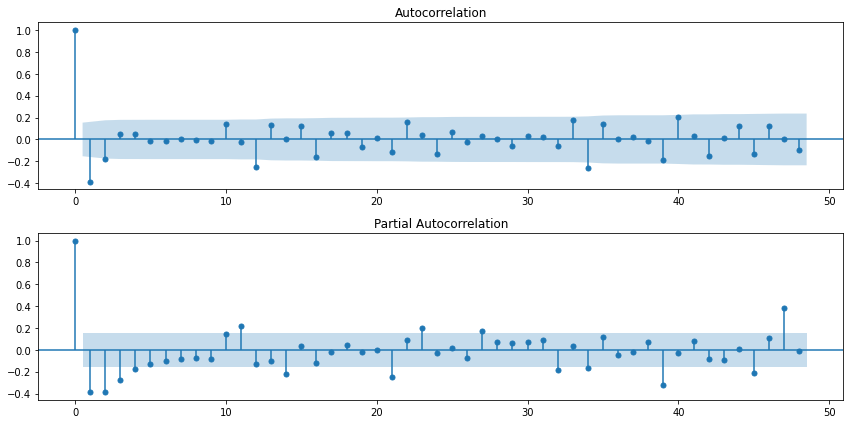

In [133]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
sm.graphics.tsa.plot_acf(data['sales_box_cox_seas_diff_1'][13:].values.squeeze(), lags=48, ax=ax[0])
sm.graphics.tsa.plot_pacf(data['sales_box_cox_seas_diff_1'][13:].values.squeeze(), lags=48, ax=ax[1])
plt.tight_layout()

По графику ACF будем определять начальные приближения q и Q:
- Q: 1 (максимальный сезонный лаг который значим, учитывая длину сезона)
- q: 2 (максимальный несозонный лаг который значим )

По графику PACF будем определять начальные приближения для p и P:
- P: 1 (максимальный сезонный лаг который значим, учитывая длину сезона)
- p: 4 (максимальный несозонный лаг который значим)

Учитывая теперь наши начальные приближения осуществим перебор данных параметров для модели

In [161]:
# Начальные приближения
Q = range(0,2) # 0-1
q = range(0,3) # 0-2

p = range(0,5) # 0-4
P = range(0,2) # 0-1

D = 1 # сезооные разности были применены 1 раз
d = 1 # первые разности были применены 1 раз
s = 12 # длина сезона

In [162]:
# Взглянем на общее число комбинаций
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print('Total Params Combinations: ', len(parameters_list))

Total Params Combinations:  60


### Обучаем модель 

In [172]:
%%time

results = []
best_aic = float('inf')

for param in parameters_list:
    # Т.к. моедель не обучается на некоторых параметрах, то заключим критичный код в try-except блок
    try:
        model = sm.tsa.statespace.SARIMAX(data['sales_box_cox'],
                                          order=(param[0], d, param[1]), # p,d,q params
                                          seasonal_order=(param[2], D, param[3], s) # P, D, Q, s params
                                         ).fit(disp=-1)
        
    # Если модель не обучается на каких-то параметрах, выводим их 
    except ValueError:
        print('Wrong Params: ', param)
        continue
        
    # Смотрим на значения информационного критерия Акайке и сохраняем лучшую модель 
    current_aic = model.aic
    if current_aic < best_aic:
        best_model = model
        best_aic = current_aic
        best_param = param
        
    results.append([param, current_aic])

Wall time: 22.3 s


In [179]:
# Результаты 
modesl_results = pd.DataFrame(results)
modesl_results.columns = ['params', 'aic']

# Выводим топ-5 лучших 
modesl_results.sort_values(by='aic').head()

,params,aic
21,"(1, 2, 0, 1)",1006.024314
29,"(2, 1, 0, 1)",1007.801388
31,"(2, 1, 1, 1)",1008.786373
45,"(3, 2, 0, 1)",1009.167726
33,"(2, 2, 0, 1)",1009.284102


Взглянем на иформацию о лучшей модели

In [182]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                        sales_box_cox   No. Observations:                  176
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -498.012
Date:                              Sat, 20 Feb 2021   AIC                           1006.024
Time:                                      10:46:01   BIC                           1021.493
Sample:                                  01-01-1980   HQIC                          1012.304
                                       - 08-01-1994                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9103      0.053     17.037      0.000       0.806       1.015
ma.L1         -1.93

Визуальный анализ остатков модели 

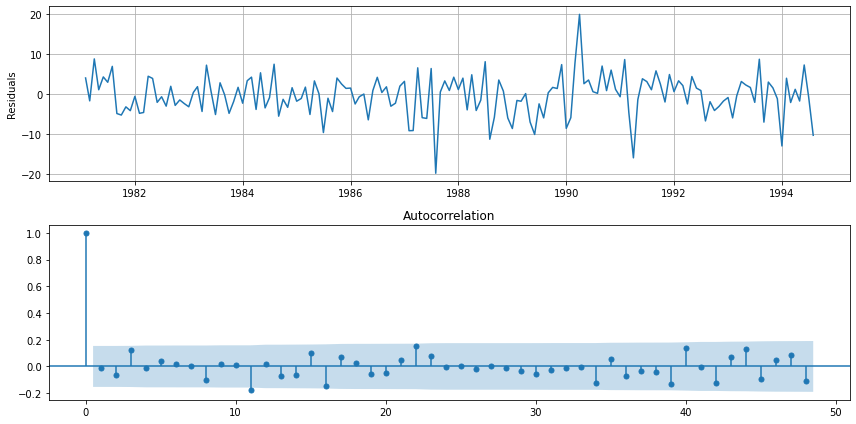

In [201]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
ax[0].plot(best_model.resid[13:])
ax[0].grid(True)
ax[0].set_ylabel('Residuals')

sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax[1])
plt.tight_layout()

In [ ]:
print("Diki-Fuller Criterion: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])
print("Student's Criterion: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Следовательно, наша модель хороша.


Посмотрим, насколько хорошо модель описывает данные:

In [205]:
data['model_pred'] = box_cox_transformation(series=best_model.fittedvalues, lmbda=lmbda)

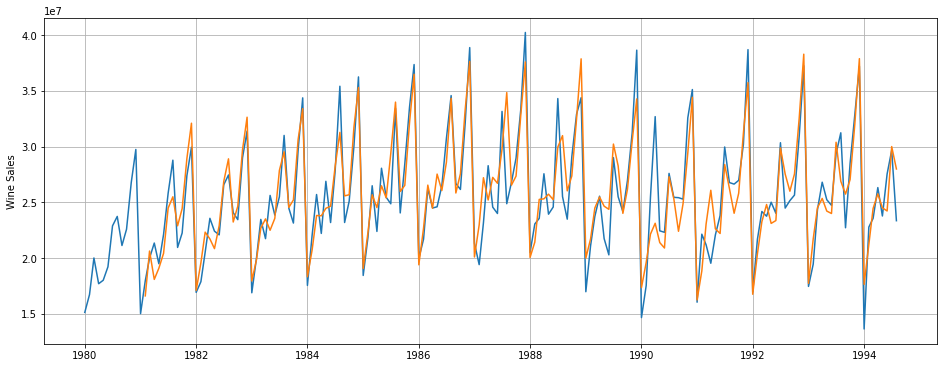

In [210]:
plt.figure(figsize=(16, 6))
plt.plot(data['sales'], label='Original')
plt.plot(data['model_pred'][13:], label='Model')
plt.ylabel('Wine Sales')
plt.grid(True);

### Прогнозирование

In [223]:
# Отбираем основной ряд и оформляем как df
origianl_series = data[['sales']]

# Создадим наше окно предсказаний, например, на 3 года (36 месяцев)
dates_list = [datetime.datetime.strptime("1994-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)] 

# Объединяем датафреймы для получения горизонта предсказаний
preds_df = pd.DataFrame(index=dates_list, columns=origianl_series.columns)
origianl_series = pd.concat([origianl_series, preds_df])
origianl_series

In [227]:
forecast = best_model.predict(start=176, end=211) # start - последние известное значение для исходного ряда

# Т.к. наша модель настроена на значения преобразованные методом Бокса-Кокса то
# предсказания необходимо преобразовать обратно (т.е. сделать обратное преобразование Бокса-Кокса)
origianl_series['model_forecast'] = box_cox_transformation(series=forecast, lmbda=lmbda)

### Прогноз модели на 3 года

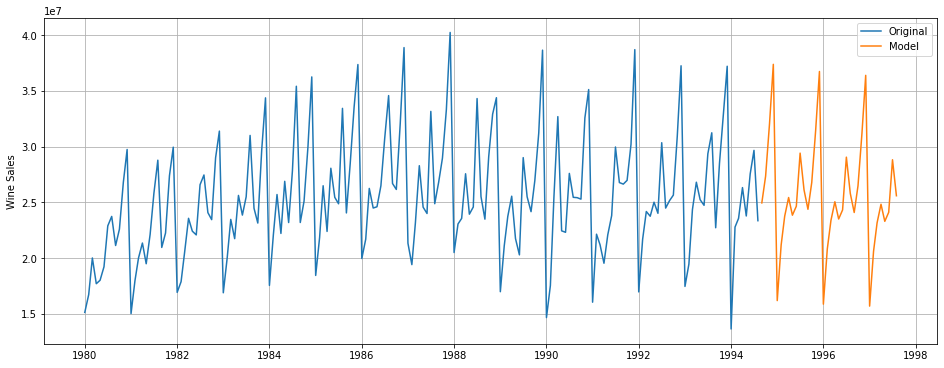

In [231]:
plt.figure(figsize=(16, 6))
plt.plot(origianl_series['sales'], label='Original')
plt.plot(origianl_series['model_forecast'], label='Model')
plt.ylabel('Wine Sales')
plt.grid(True)
plt.legend();

Прогноз выглядит достаточно адекватным. Он передаёт то, что мы знаем о сезонности, глядя на предыдущий кусок ряда, и в нём, в принципе, нет тренда. Ну, это тоже можно понять, потому что тренд имел достаточно сложную структуру, и похоже, вот в тот момент, в который мы делаем предсказание, очень сложно знать заранее, будет ли средний уровень ряда дальше повышаться или понижаться. Прогноз достаточно адекватный.